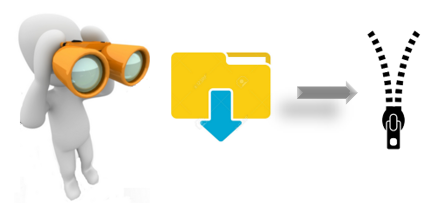

Many times we download files they come in .zip format. The manual process to unblock and extract those files is quite cumbersome. Therefore I would like to walk you through the creation of a PowerShell function that will monitor a download folder for incoming .zip files and then automatically (smartly more than below) extract the files.
The function should meet the following requirements:
- Run in the background and not block input on the PowerShell prompt.
- Use limitited resources for the constant monitoring of the folder.
- Ability to specify the download folder to be monitored.
- Ability to specifiy whether to keep or remove the .zip file after extraction of the files.
- Unblock the .zip file prior to the extraction.
- Smart extraction: If the .zip files are already contained in a folder within the .zip just extract the file as is otherwise extract the .zip to a dedicated folder.

Luckily, there is already a .Net object that can take care of the monitoring part in the background (asynchronous). The [FileSystemWatcher](https://docs.microsoft.com/en-us/dotnet/api/system.io.filesystemwatcher?view=net-5.0) class and even more fortuante is, that I have already created a PowerShell wrapper to monitor a folder (below without comment based help to save some space the full version can be downloaded as part of my [PowerShellScripts](https://github.com/DBremen/PowerShellScripts) module:

In [ ]:
function Monitor-Folder {
    [CmdletBinding()]
    Param
    (
        [Parameter(Mandatory = $true, ValueFromPipeline = $true, Position = 0)]
        [ValidateScript( {
                if (-not (Test-Path $_ -PathType Container)) {
                    throw "Path '$_' does not exist. Please provide the path to a an existing folder."
                }
                $true
            })]
        $Folder,

        [Parameter(Position = 1)]
        [ValidateSet('All', 'Changed', 'Created', 'Deleted', 'Renamed')]
        [String[]]
        $EventName = 'All',

        $Filter = "*",

        [string]$EventIdentifierPrefix = (Get-Random),

        [scriptblock]$Action,

        [IO.NotifyFilters]$NotifyFilter =  'FileName, LastWrite',

        [switch]$Recurse,

        [switch]$DefaultOutput
    )
    if (!$DefaultOutput -and !$Action) {
        throw "Please provide a scriptblock for the action parameter or use the 'defaultOutput' switch for the default output"
    }
    $fsw = New-Object IO.FileSystemWatcher $Folder, $Filter -Property @{
        IncludeSubdirectories = $Recurse
        NotifyFilter          = $NotifyFilter
    }
    $defaultAction = {
        $name = $event.SourceEventArgs.Name
        $fullName = $event.SourceEventArgs.FullPath
        $changeType = $event.SourceEventArgs.ChangeType
        $time = $event.TimeGenerated
    }
    $renameAction = {
        $name = $event.SourceEventArgs.Name
        $fullName = $event.SourceEventArgs.FullPath
        $oldName = $event.SourceEventArgs.OldName
        $oldFullName = $event.SourceEventArgs.OldFullName
        $changeType = $event.SourceEventArgs.ChangeType
        $time = $event.TimeGenerated
    }
    if ($DefaultOutput) {
        $defaultAction = [scriptblock]::Create($defaultAction.ToString() + ';' + 'Write-Host "The file ''$name'' was $changeType at $time"')
        $renameAction = [scriptblock]::Create($renameAction.ToString() + ';' + 'Write-Host "The file ''$oldName'' was $changeType to ''$name'' at $time"')
    }
    if ($Action) {
        $defaultAction = [scriptblock]::Create($defaultAction.ToString() + "`n" + $Action.ToString())
        $renameAction = [scriptblock]::Create($renameAction.ToString() + "`n" + $Action.ToString())
    }

    if ($EventName -eq 'All') { $EventName = 'Changed', 'Created', 'Deleted', 'Renamed' }

    $eventHandlers = foreach ($evt in $EventName) {
        if ($evt -eq 'Renamed') {
            Register-ObjectEvent $fsw $evt -SourceIdentifier ($EventIdentifierPrefix + "_" + $evt) -Action $renameAction
        }
        else {
            Register-ObjectEvent $fsw $evt -SourceIdentifier ($EventIdentifierPrefix + "_" + $evt) -Action $defaultAction
        }
    }
    $fsw.EnableRaisingEvents = $true
    [PSCustomObject][ordered]@{
        Watcher = $fsw
        Events  = $eventHandlers
    }
}

The function is just a convenience wrapper. We can easily monitor a folder like this:

In [ ]:
$monitor = Monitor-Folder "$env:USERNAME\Desktop" -EventName All -DefaultOutput

The default output of the function looks similar to this:

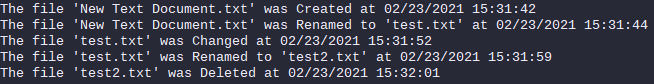

The highlight of Monitor-Folder is the ability to refer to the event variables directly from within the provided $Action ScriptBlock (this ScriptBlock is executed when the monitored event is triggered):

In [ ]:
$folder = "$env:USERPROFILE\Desktop\test\Desktop\test"
$action = {Write-host "$fullName was deleted at $time";[console]::beep(500,500)}
$monitor = Monitor-Folder $folder -EventName Deleted -Action $action

Those are the variables that are available within the Action ScriptBlock argument for Monitor-Folder:

| Variable Name | Events | Description |
|-|-|-|
| name | All | The name of the file the event was triggered for. |
| fullName | All | The fullName (Path) of the file the event was triggered for. |
| changeType | All | The type of event that was triggered. |
| time | All | When the event was triggered. |
| oldName | Renamed | The original name of the file. |
| oldFullName | Renamed | The original fullName (path) of the the file. |

To stop the monitoring and clean up the resources the following commands can be used:

In [ ]:
$monitor.Watcher.EnableRaisingEvents = $false
$monitor.Events | ForEach-Object {
    Unregister-Event -SourceIdentifier $_.Name
}
$monitor.Events| Remove-Job
$monitor.Watcher.Dispose()

With several of the requirements already checked, we can now focus on the remaining one's. All of the operations we want to execute on the .zip file will happen within the $Action ScriptBlock provided to the Monitor-Folder function. While testing downloads in Chrome and FireFox I noticed that for Chrome the Renamed event is triggered for downloaded files while for FireFox it is the Created event. Therefore we must Monitor for both.

In [ ]:
$keep = $false
$donwloadFolder = "$env:USERPROFILE\Desktop"
$action = {
    try {
        Add-Type -Assembly 'System.IO.Compression.FileSystem'
        Unblock-File $fullName
        #check if the .zip content is in a  folder with the same name
        $fileName = [IO.Path]::GetFileNameWithoutExtension((Split-Path $fullName -Leaf))
        $parentFolder = Split-Path $fullName
        $folderPath = Join-Path $parentFolder $fileName
        #Firefox will trigger two create events of which the first will fail here therefore we use try catch
        $hasFolder = ([IO.Compression.ZipFile]::OpenRead($fullname).Entries.where{ $_.FullName -eq "$fileName/" }).Count -eq 1
        $destFolder = Split-Path $fullName
        if ((-not $hasFolder) -or (Test-Path $folderPath)) {
            $postFix = 0
            while (Test-Path $folderPath) {
                $folderPath = (Join-Path $parentFolder $fileName) + $postFix
                $postFix++
            }
            $destFolder = New-Item -ItemType Directory -Path $folderPath
        }
        Expand-Archive $fullName $destFolder
        if (-not $keep){
            Remove-Item $fullName
        }
    }
    catch {}
}
$monitor = Monitor-Folder $downloadFolder -EventName Created, Renamed  -Filter *.zip -Action $action -NotifyFilter 'FileName, Size'


For the "smart" extraction we use the [IO.Compression.ZipFile]::OpenRead to peek into the .zip file in order to find out whether the .zip files are already contained in a folder with the same name as the .zip file. If the .zip files are not already contained within a folder we will create one while taking care of the scenario if there is already a folder with the same name as the .zip file. Other than that we specify a filter to only monitor .zip files within the specified folder and change the NotifyFilter to be based on FileName and Size of the file. This is in order to avoid most of the duplicate events being triggered by the download of the file. During my tests Firefox still raised two Created events for every download. In that case the OpenRead method on the .zip file will fail for the first event since the file hasn't been finished downloading. The rather unelegant workaround for this is to put the whole action block into a try catch construct.

The only requirement that is not met is putting the whole script into a background thread. Rather than re-inventing the wheel, I'd like to make use of the excellent ThreadJob module that already comes with PowerShell 7. For any other version the module can be installed via:

In [ ]:
Install-Module ThreadJob

Now we will need to add an infinitive loop in order to keep the thread running in the background. In addition we can use \\$using:VARIABLENAME in order to feed the arguments into the ScriptBlock that runs in another thread. Here is the whole funciton (again the full version including comment based help can be downloaded from my [GitHub repo]((https://github.com/DBremen/PowerShellScripts)).

In [ ]:
function Expand-ArchiveAutomamtically {
    #Requires –Modules ThreadJob
    [CmdletBinding()]
    Param
    (
        $DownloadFolder = "$env:USERPROFILE\Desktop\",
        [switch]$Keep
    )
    $job = {
        $action = {
            try {
                Add-Type -Assembly 'System.IO.Compression.FileSystem'
                Unblock-File $fullName
                #check if the .zip content is in a  folder with the same name
                $fileName = [IO.Path]::GetFileNameWithoutExtension((Split-Path $fullName -Leaf))
                $parentFolder = Split-Path $fullName
                $folderPath = Join-Path $parentFolder $fileName
                #Firefox will trigger two create events of which the first will fail here
                $hasFolder = ([IO.Compression.ZipFile]::OpenRead($fullname).Entries.where{ $_.FullName -eq "$fileName/" }).Count -eq 1
                $destFolder = Split-Path $fullName
                if ((-not $hasFolder) -or (Test-Path $folderPath)) {
                    $postFix = 0
                    while (Test-Path $folderPath) {
                        $folderPath = (Join-Path $parentFolder $fileName) + $postFix
                        $postFix++
                    }
                    $destFolder = New-Item -ItemType Directory -Path $folderPath
                }
                Expand-Archive $fullName $destFolder
                #see https://docs.microsoft.com/en-us/powershell/module/microsoft.powershell.core/about/about_thread_jobs?view=powershell-7.1
                if (-not $using:Keep) {
                    Remove-Item $fullName
                }
            }
            catch {}
        }
        $monitor = Monitor-Folder $using:DownloadFolder -EventName Created, Renamed  -Filter *.zip -Action $action -NotifyFilter 'FileName, Size'
        do {
            Wait-Event -Timeout 1
        } while ($true)
    }
    $scriptBlock = [ScriptBlock]::Create('function Monitor-Folder{' + (Get-Command Monitor-Folder).Definition + '}' + $job.ToString())
    return Start-ThreadJob -ScriptBlock $scriptblock
}

The usage of the function is very easy.

In [ ]:
# start expanding .zip files automatically within the user's download folder while removing the original zip files (no keep switch)
$job = Expand-ArchiveAutomamtically -DownloadFolder "$env:USERPROFILE\Downloads"
# stop and remove the job if desired
$job | stop-job | remove-job

Of course, if you want to use this on a regular basis you should put this into your profile.